# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [285]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


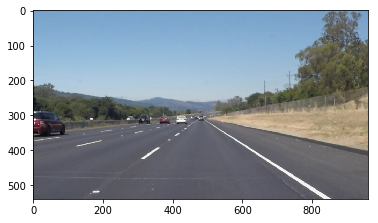

In [286]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [287]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [288]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline

Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

### Development Images

The test images look like this:

In [289]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
# Helper function to plot an array of images
def plot_images(array_of_images, color_map=None):
    num_images = len(array_of_images)

    fig = plt.figure(figsize=(15,15))
    for i in range(num_images):
        a = fig.add_subplot(3, 2, i+1)
        title = "Image " + str(i+1)
        a.set_title(title)
        plt.imshow(array_of_images[i],cmap=color_map)

    plt.show()

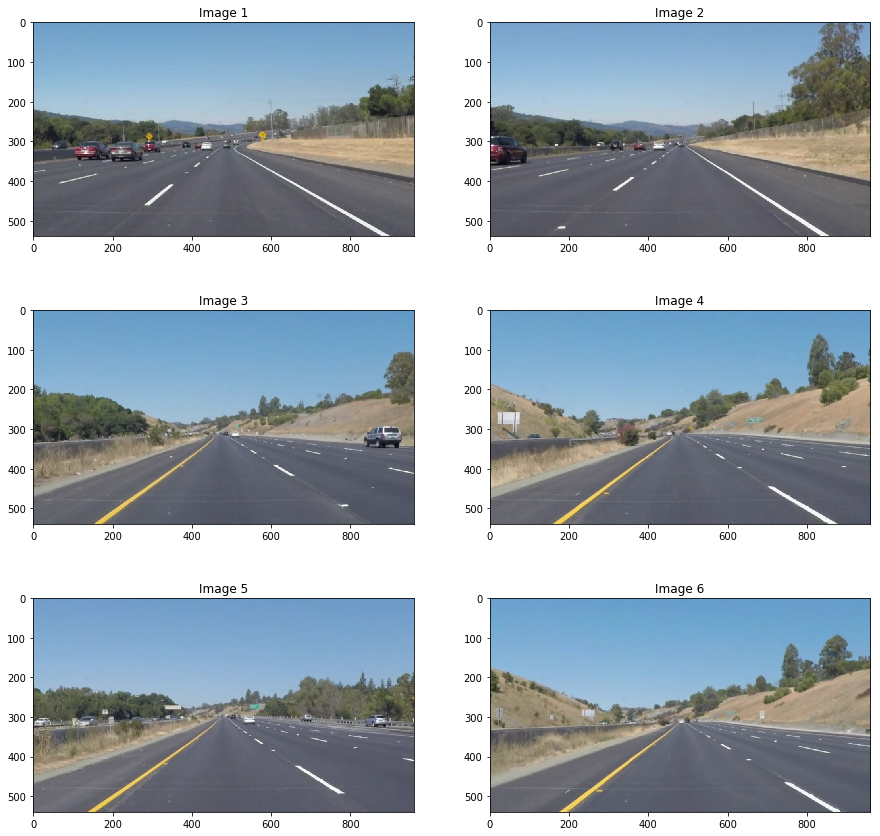

In [290]:
# Display original test images
input_folder = "test_images/"
os.listdir(input_folder)
test_images = [mpimg.imread(os.path.join(input_folder, filename)) for filename in os.listdir(input_folder)]

plot_images(test_images)

It can be seen that the lane lines we need to identify are either colored white or yellow. Some lane lines are comprised of alternating dots and short line segments, while others are continuous.

### Pipeline Step 1: Select Colors of Interest

#### Color Conversion

It is possible to select the white and yellow parts of an image in RGB color space. However in the Intro to Self-Driving Cars Nanodegree I learned that conversion to either HSV or HLS color space before selection will give better results. HSV/HLS color spaces allow better color selection in case of shades or other suboptimal light conditions, as is present in the challenge.mp4 video.

In [291]:
# Helper functions
def convert_to_hsv(im):
    return cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
    
def convert_to_hls(im):
    return cv2.cvtColor(im, cv2.COLOR_RGB2HLS)

#### HSV Images

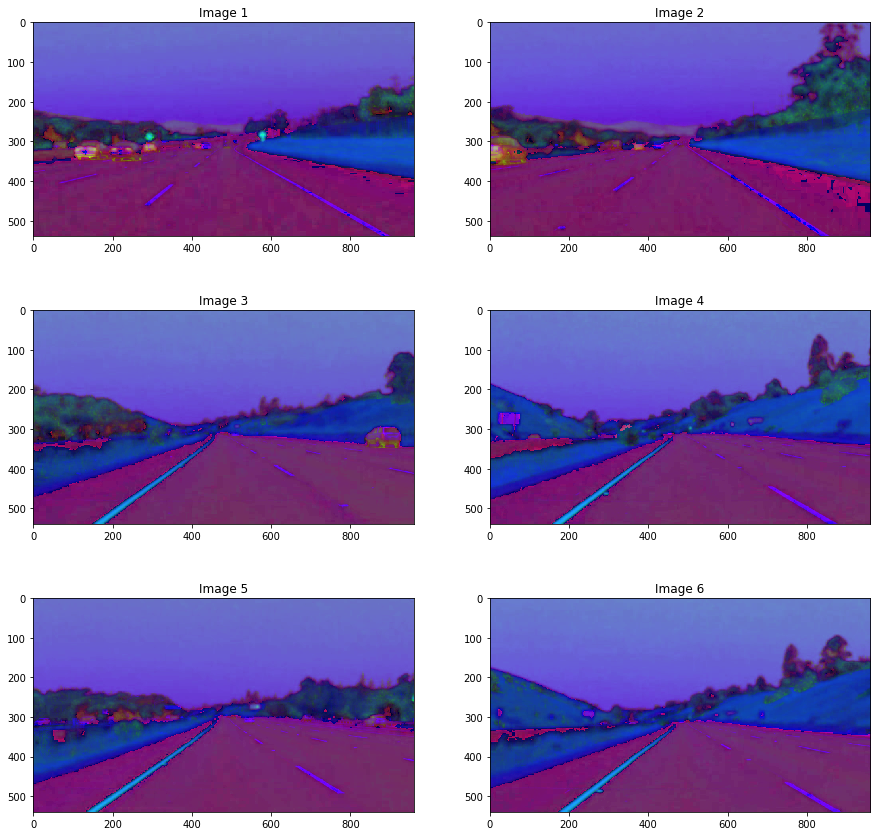

In [292]:
# Convert to HSV and display
hsv_images = list(map(convert_to_hsv, test_images)) # HSV conversion
plot_images(hsv_images)

#### HLS Images

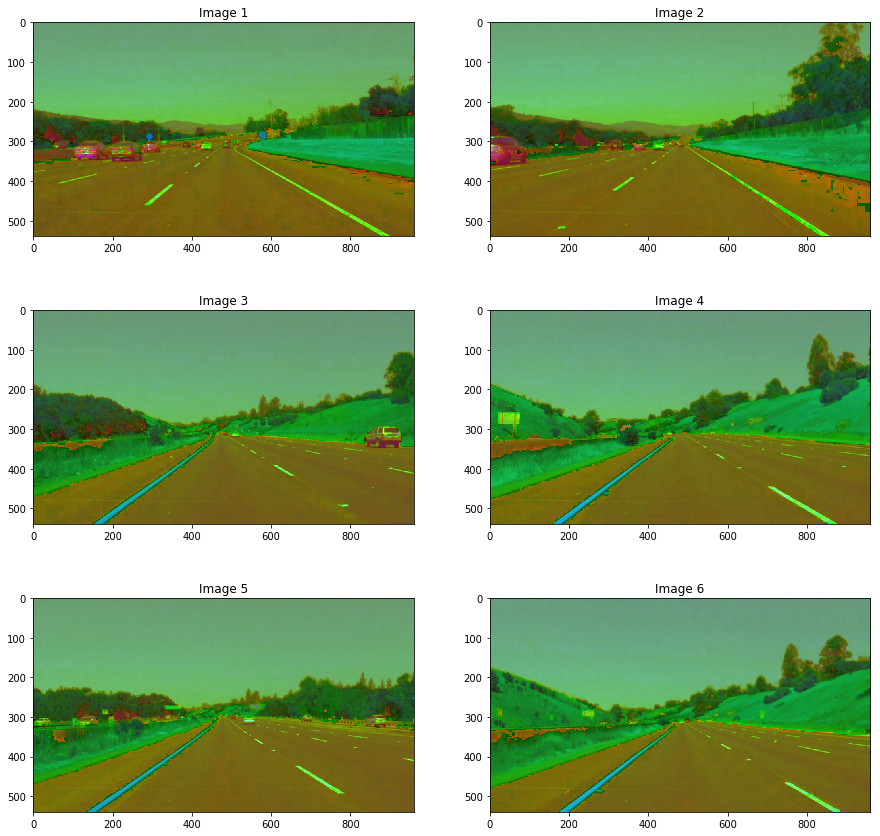

In [293]:
hls_images = list(map(convert_to_hls, test_images)) # HLS conversion
plot_images(hls_images)

output_folder = "test_images_output/hls"
for i in range(len(hls_images)):
    mpimg.imsave( os.path.join(output_folder, "Image"+str(i)+".jpg"), hls_images[i] )

As it can be seen the HSL converted images appear to provide the best possiblity for finding the lane lines of interest. Both the yellow and the white lines are clearly recognizable.

I will move on using the HLS converted images.

#### Color Selection

Next step is to select the white and yellow parts of the image. This is done using the OpenCV library. I used the following documentation:

http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html

I will use the cv2.InRange function to find the white and yellow colors of the HLS images. The function takes as input an image and ranges for the H, L and S values. The function will return a binary mask of the same size as the input image in which pixels falling into the input ranges will have value 255 (corresponding to the color white in RGB color space), and 0 (corresponding to the color black in RGB color space) when outside of the input ranges.

So first I will define color masks for the white and yellow lines based on the HLS version of the image. Finding good values for the color masks takes a little experimentation and tuning.

For the white color mask I will filter out the parts with a very high Lightness (L) value, and perform no filtering of Hue (H) and Saturation (S).

For the yellow color mask I looked at an HLS color picker and selected a Hue value of 30 as the center of the yellow color range. Further I will select a high Saturation value to avoid detecting yellowish surroundings of the road.

I will then combine the 2 color masks using the function cv2.bitwise_or, and apply the combined color mask to the original image using cv2.bitwise_and. The result will be a new image in which the yellow and white parts are visible, and the rest black.

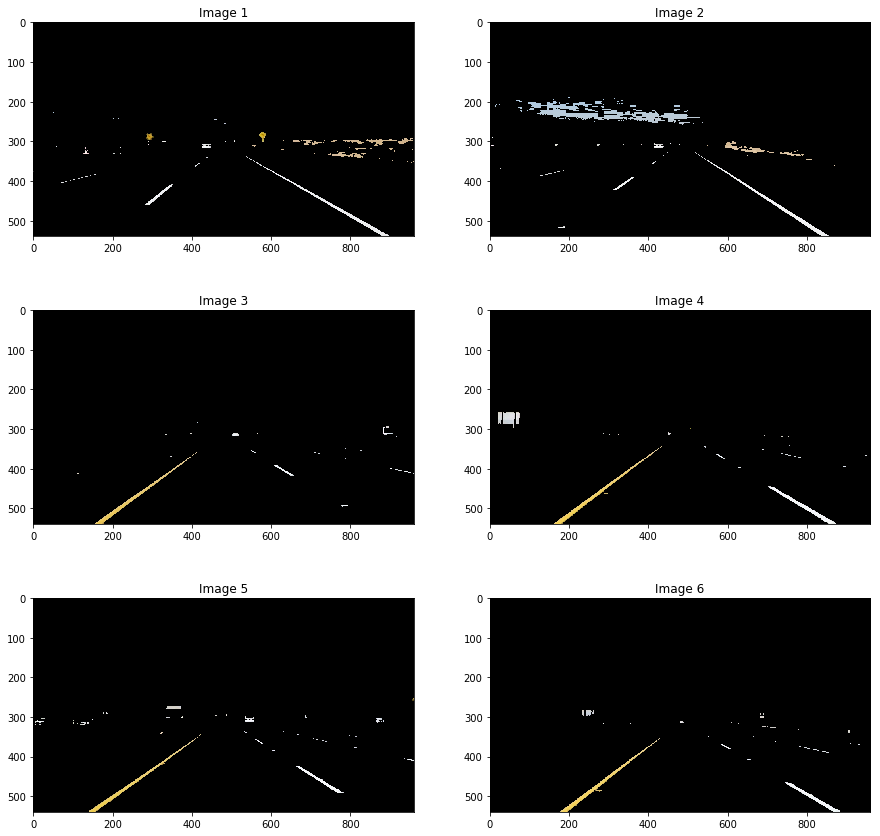

In [294]:
def do_white_and_yellow_color_selection(im):
    # First convert input image to HLS
    hls_image = convert_to_hls(im)
    
    # White color mask. Filter only on the Lightness value
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(hls_image, lower, upper)
    
    # Yellow color mask
    # Use Hue value 30 +/- 10 and high Saturation. Lightness is not filtered
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(hls_image, lower, upper)
    
    # Combine the masks
    combined_mask = cv2.bitwise_or(white_mask, yellow_mask)
    
    # Apply combined mask to the original image and return a copy with the result.
    return( cv2.bitwise_and(im, im, mask = combined_mask) )

white_yellow_images = list(map(do_white_and_yellow_color_selection, test_images))
plot_images(white_yellow_images)

output_folder = "test_images_output/white_yellow"
for i in range(len(white_yellow_images)):
    mpimg.imsave( os.path.join(output_folder, "Image"+str(i)+".jpg"), white_yellow_images[i] )

### Pipeline Step 2: Select Area of Interest

Before moving on with the processing intensive tasks of Canny edge detection and Hough transformation based line detection it makes sense to limit the problem by selecting only the relevant part of the image.

By inspecting the images it can be seen that the real area of interest is a polygon in the lower half (well higher half as (0,0) is the upper left corner) of the image. Further we can exclude parts of both sides of the image.

It is reasonable to limit the area of interest because the camera is mounted in a fixed spot on the car, and therefore all images for lane line detection will be similar. Obviously we have to be careful not to limit the area of interest too much. Especially when the road is curved the lane lines will move inside the images as well. The techniques applied here is anyway only good for lane lines who are approximately straight lines.

I will use the function cv2.fillPoly to select the area of interest. This function requires the corner points of the 4 sides of the polygon.

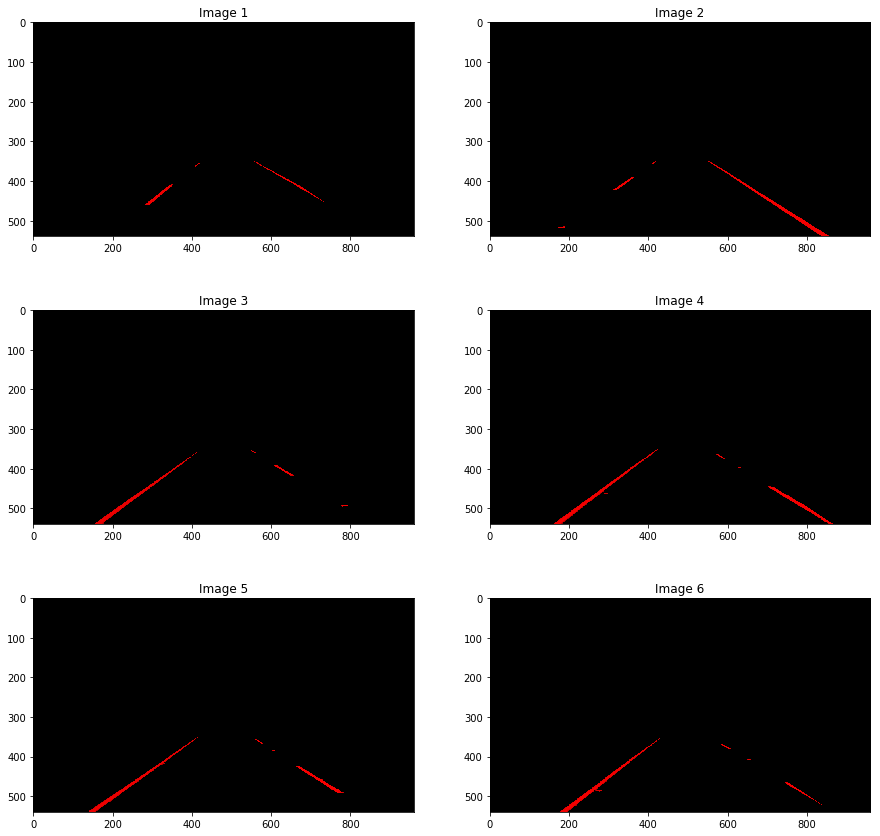

In [295]:
def crop_to_area_of_interest(im):
    # Define the corners of the area of interest
    max_y = im.shape[0] # Max y value
    max_x = im.shape[1] # Max x value
    
    # Define the polygon
    bottom_left = [int(max_x*0.1), max_y] # cv2.fillPoly would like the points in the (x,y) form
#    print(bottom_left)
    bottom_right = [int(max_x*0.9), max_y]
#    print(bottom_right)
    top_left = [int(max_x*0.4), int(max_y*0.65)]
#    print(top_left)
    top_right = [int(max_x*0.6), int(max_y*0.65)]
#    print(top_right)
    
    # Define the polygon as an array of points
    polygon = [bottom_left, top_left, top_right, bottom_right]
    
    # Create copy of input image with same shape and all values set to 0 (black)
    area_mask = np.zeros_like(im)
    
    # Set all values inside the polygon to 255 (white)
    cv2.fillPoly(area_mask, np.array([polygon]), 255)
    
    # Use bitwise_and to return a new image containing only the parts inside the polygon
    # the rest set to black
    return( cv2.bitwise_and(im, area_mask) )
    
cropped_images = list(map(crop_to_area_of_interest, white_yellow_images))
plot_images(cropped_images)

output_folder = "test_images_output/cropped"
for i in range(len(cropped_images)):
    mpimg.imsave( os.path.join(output_folder, "Image"+str(i)+".jpg"), cropped_images[i] )

### Pipeline Step 3: Canny Edge Detection

Now we have images containing only the colors on interest in the area of interest. We will apply the Canny Edge Detection algorithm in order to find points which can be part of straight lines. The Canny Edge Detection is described for example here:

https://en.wikipedia.org/wiki/Canny_edge_detector

Essentially what happens is to detect edges in an image by finding where the images change color. In order to do this effectively images must first be converted to gray scale, and second blurring must be applied to smoothe rough edges.

#### Convert to Grayscale

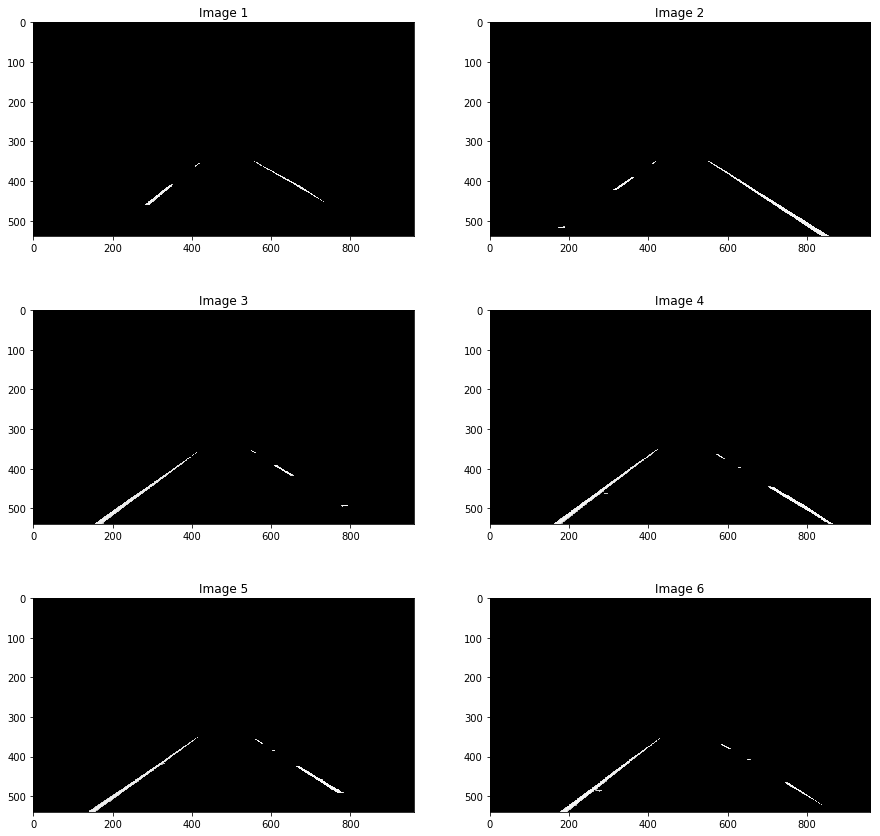

In [296]:
# Use provided helper function
gray_images = list(map(grayscale, cropped_images))
plot_images(gray_images, 'gray')

#### Blurring

Edges in images are places where pixel color values change rapidly. In our case we would expect to see color value change from something very low (0 being black) to something very high (255 being completely white). Blurring will essentially make such value changes smaller, and will have the effect of reducing noise in the edge detection.

OpenCV provides the function cv2.GaussianBlur as one way of applying blurring to images. The GaussianBlur function requires a kernel_size value as input. This value defines how wide pixels values are spread to the neighbor pixels. Consequently the value must be an odd (positive) number, and the larger the number the more the image is blurred. Obviously the larger the kernel_size value, the more processing intensive the convolution operation will become.

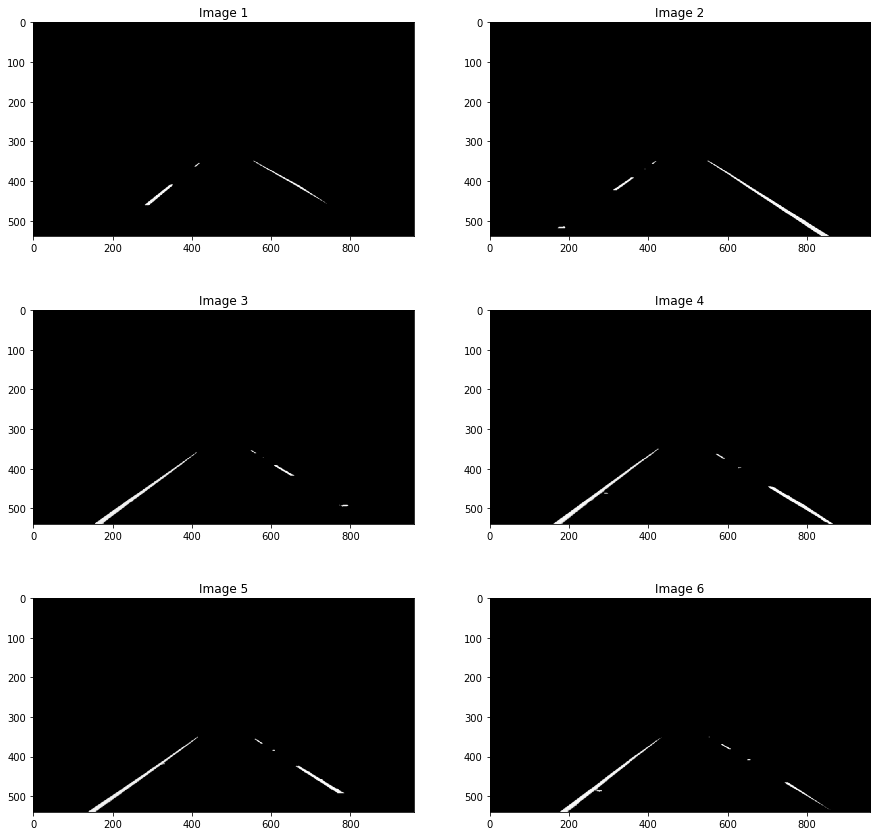

In [297]:
def blur_image(im, kernel_size=3):
    return( cv2.GaussianBlur(im, (kernel_size, kernel_size), 0) )
    # Parameter 0 means the standard deviation in x and y direction is calculated from the kernel size

# Blur
blurred_images = list(map(blur_image, gray_images))
plot_images(blurred_images, 'gray')

#### Edge Detection

We are lucky that OpenCV also provides a function cv2.Canny for the edge detection. The Canny function takes 2 threshold values as input minVal and maxVal. According to:

http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html

"any edges with intensity gradient more than maxVal are sure to be edges and those below minVal are sure to be non-edges, so discarded. Those who lie between these two thresholds are classified edges or non-edges based on their connectivity. If they are connected to “sure-edge” pixels, they are considered to be part of edges. Otherwise, they are also discarded."

Recommended is a ration between 2:1 and 3:1 between the threshold values. Actual values must be determined by trial and error.

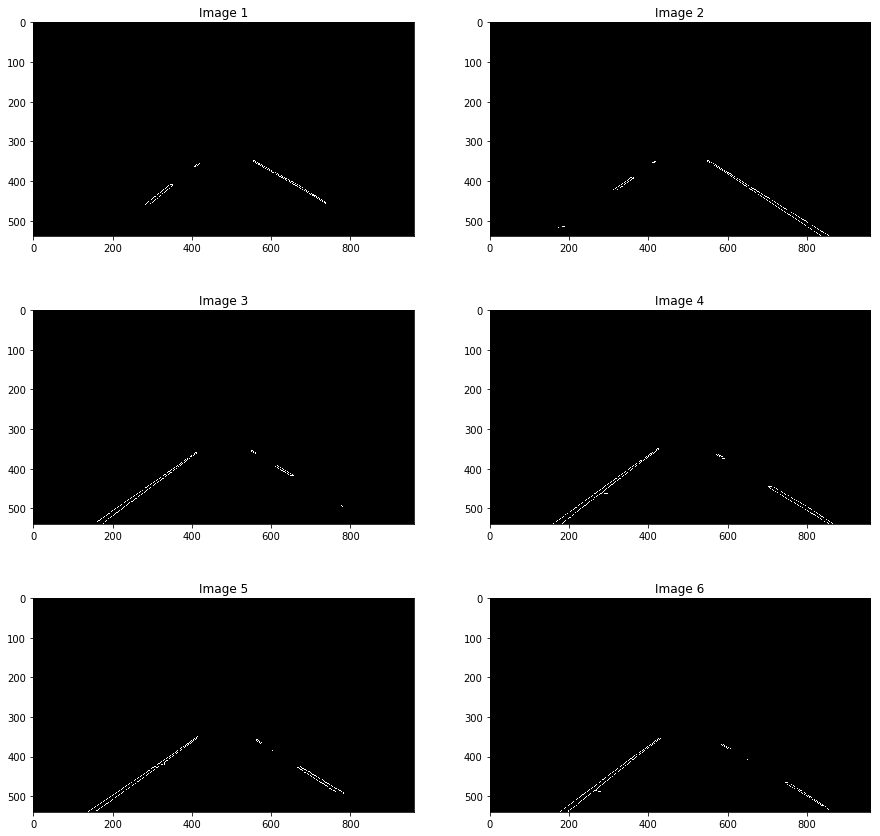

In [298]:
def detect_edges(im, low=50, high=150):
    return( cv2.Canny(im, low, high) )

# Find edges
edges_images = list(map(detect_edges, blurred_images))
plot_images(edges_images, 'gray')

output_folder = "test_images_output/canny"
for i in range(len(edges_images)):
    mpimg.imsave( os.path.join(output_folder, "Image"+str(i)+".jpg"), edges_images[i], None, None, 'gray' )

### Pipeline Step 4: Hough Transformation for Straight Line Detection

Hough transformation for straight line detection is based on how a line in (x,y) space can be represented in polar coordinates

rho = distance of line from (0,0)
theta = angle of line from hortizontal

rho = x * cos(theta) + y * sin(theta)

So a line in a (x, y) space can be mapped to single a point in a (rho, theta) space.

This can be utilized by drawing a number of lines through each pixel in the image of edges. Each line becomes a point in (rho, theta) space. Now if several pixel points sit on the same straight line on the (x,y) image of edges, they will map to the same point in (rho, theta) space. So finding straight lines becomes a matter of finding pixels who map to the same (rho, theta) value.

What I describe as drawing a number lines through each pixel of the edge image actually is a brute force way of finding points on the same line.

Luckily OpenCV provides functions to do this for us. OpenCV also provides a good explanation of the theory behind the mapping of lines in (x,y) space to points in (rho, theta) space:

https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html

I will use the function cv2.HoughLinesP to do the job. According to the above documentation this function is an optimized hough transformation which requires less computation that the full version.

The function requires 5 main parameters which require explanation. The explanation is also taken from the above URL.

- rho: accuracy of rho in pixels of the applied lines
- theta: accuracy of the theta angle in radians of the applied lines
- threshold: required minimum number of points on a line
- minLineLength: required minimum length of a line
- maxLineGap: maximum allow gap between points on a line 

Furthermore it is relevant to say that HoughLinesP directly returns the 2 endpoints of each identified line in the form of x1,y1,x2,y2.

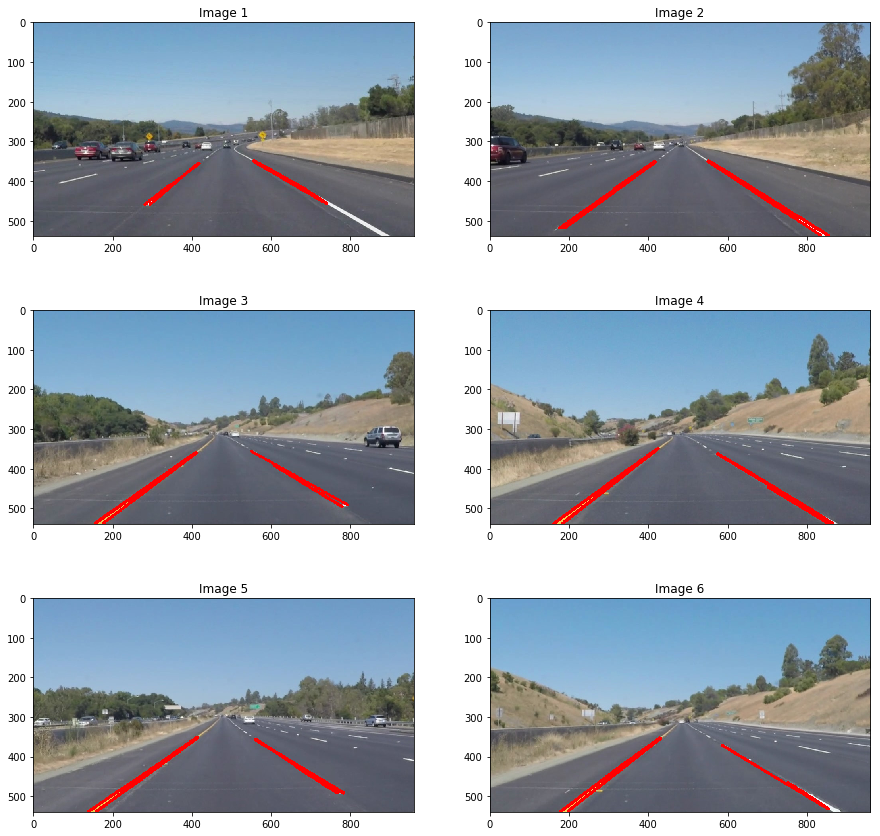

In [299]:
def find_hough_lines(im, rho=1, theta=(np.pi/180), threshold=30, minLineLength=50, maxLineGap=300):
    return(cv2.HoughLinesP(im, rho, theta, threshold, np.array([]), minLineLength, maxLineGap))

hough_lines = list(map(find_hough_lines, edges_images))

# Helper function to plot a list hough lines on to an image
def draw_hough_lines_on_image(list_of_lines, im):
    im_copy = np.copy(im)
    
    for line in list_of_lines:
        for x1, y1, x2, y2 in line:
            cv2.line(im_copy, (x1,y1), (x2,y2), (255,0,0), 5 )

    return(im_copy)

# Another helper function to display hough lines on our set of test images
def draw_lines_and_images(array_of_images, array_of_array_of_lines, color_map=None):
    output_folder = "test_images_output/hough"
    num_images = len(array_of_images)

    fig = plt.figure(figsize=(15,15))
    
    for i in range(num_images):
        if array_of_array_of_lines[i] is None:
            print("No lines found by HoughLinesP for image " + str(i+1))
        else:
            im_to_draw = draw_hough_lines_on_image(array_of_array_of_lines[i], test_images[i])

            a = fig.add_subplot(3, 2, i+1)
            title = "Image " + str(i+1)
            a.set_title(title)
            plt.imshow(im_to_draw, cmap=color_map)
            
            mpimg.imsave( os.path.join(output_folder, "Image"+str(i)+".jpg"), im_to_draw )            

    plt.show()

draw_lines_and_images(test_images, hough_lines)

### Pipeline Step 5: Collate Results

The output of the HoughLines algorithm is a list of lines. We need to turn these into 2 lines, one for each lane. Our lines are represented by the end points (x1,y1) and (x2,y2), and that is not very good for averaging. So I will convert the line end points (x1,y1) and (x2,y2) into the form of a line slope S and an intersection with the y-axis y0. S and y0 can be averaged in a meaningful way. Further I will calculate the length L of the individual line segments and use those as weighting factors when calculating the averages of S and y0. It makes sense to give more weight to longer line segments when averaging. 

In [300]:
def average_lines(list_of_lines):
    left_lines = []
    left_lengths = []
    right_lines = []
    right_lengths = []
    
    if len(list_of_lines) > 0:
        for line in list_of_lines:
            for x1, y1, x2, y2 in line:
                S = (y2 - y1)/(x2 - x1) # Definition of slope
                y0 = y1 - S*x1 # Follows from f(x) = y = S*x + y0, where S is the slope of the line
                L = np.sqrt((y2 - y1)**2 + (x2 -x1)**2) # Pythagoras
            
                if S < 0: # as (0,0) is in the upper left corner, left lines will have a negative slope
                    left_lines.append((S, y0))
                    left_lengths.append((L))
                else:
                    right_lines.append((S, y0))
                    right_lengths.append((L))
                
        # Now calulate the average values of S and y0 by multiplying each value with the corresponding line length
        # summing these values, and dividing the sum by the sum of the line lengths
        if len(left_lengths) > 0:
            average_left_line = np.dot(left_lengths, left_lines) / np.sum(left_lengths)
        else:
            average_left_line = None
        if len(right_lengths) > 0:        
            average_right_line = np.dot(right_lengths, right_lines) / np.sum(right_lengths)
        else:
            average_right_line = None
    else:
        average_left_line = None
        average_right_line = None
        
    return(average_left_line, average_right_line)

average_hough_lines = list(map(average_lines, hough_lines))

Lastly we need a function to draw the detected lines on the original image

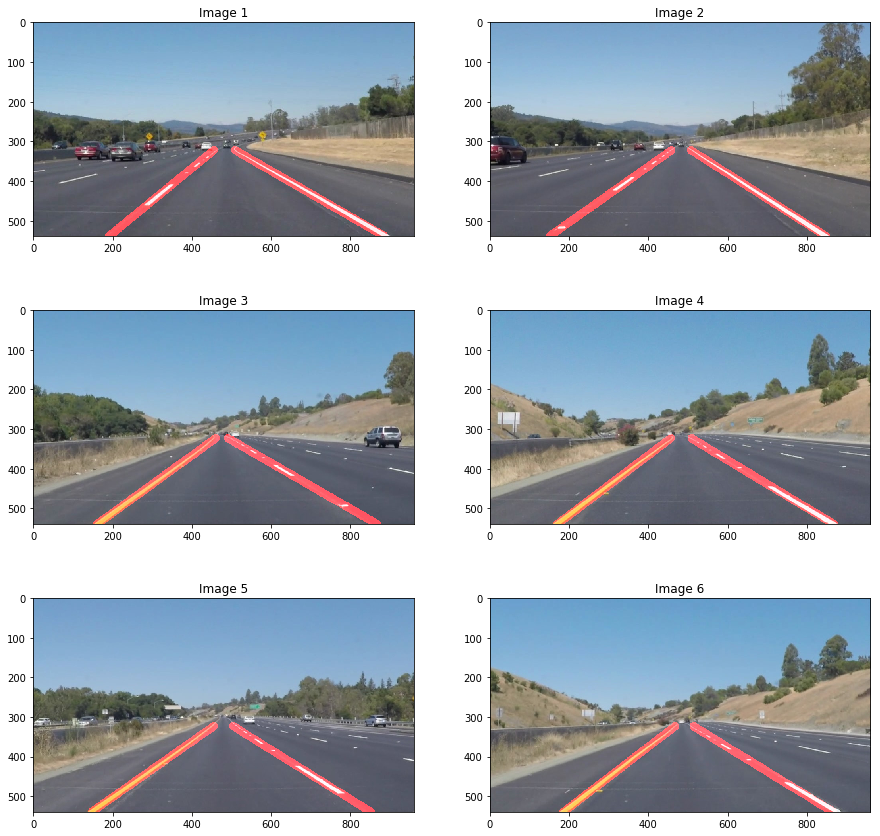

In [301]:
def draw_lane_lines(lines, im):
        # lines are in the form slope and y-intersection
        left_line = lines[0]
        right_line = lines[1]
        
        # First define 2 y values
        y1 = int(im.shape[0]) # Bottom of image
        y2 = int(0.6*y1)

        im_copy = np.zeros_like(im)

        # Use equation for straight line y = S*x + y0 to calculate corresponding x values
        if left_line is not None:
            left_S, left_y0 = left_line
            left_x1 = int((y1 - left_y0)/left_S)
            left_x2 = int((y2 - left_y0)/left_S)
            cv2.line(im_copy, (left_x1,y1), (left_x2,y2), (255,0,0), 20 )
        
        if right_line is not None:
            right_S, right_y0 = right_line
            right_x1 = int((y1 - right_y0)/right_S)
            right_x2 = int((y2 - right_y0)/right_S)
            cv2.line(im_copy, (right_x1,y1), (right_x2,y2), (255,0,0), 20 )
        
        im_with_lane_lines = cv2.addWeighted(im, 1.0, im_copy, 0.95, 0)
        
        return(im_with_lane_lines)
        
# Another helper function to display average detected lane lines on our set of test images
def draw_average_lines_and_images(array_of_images, array_of_average_hough_lines, color_map=None):
    output_folder = "test_images_output/final"
    num_images = len(array_of_images)

    fig = plt.figure(figsize=(15,15))
    
    for i in range(num_images):
        if array_of_average_hough_lines[i] is None:
            print("No lane lines found for image " + str(i+1))
        else:
            im_to_draw = draw_lane_lines(array_of_average_hough_lines[i], test_images[i])

            a = fig.add_subplot(3, 2, i+1)
            title = "Image " + str(i+1)
            a.set_title(title)
            plt.imshow(im_to_draw, cmap=color_map)
            
            mpimg.imsave( os.path.join(output_folder, "Image"+str(i)+".jpg"), im_to_draw )            

    plt.show()

draw_average_lines_and_images(test_images, average_hough_lines)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [302]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [303]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    im_copy = np.copy(image)
    # Step 1 Select colors
    white_yellow_image = do_white_and_yellow_color_selection(im_copy)
    
    # Step 2 Select region
    cropped_image = crop_to_area_of_interest(white_yellow_image)
    
    # Step 3 Canny edge detection
    gray_image = grayscale(cropped_image)
    blurred_image = blur_image(gray_image)
    edges_image = detect_edges(blurred_image)
    
    # Step 4 Hough lines
    hough_lines = find_hough_lines(edges_image)
    
    # Step 5 Collate results
    if hough_lines is None:
        result = image
    else:
        average_hough_lines = average_lines(hough_lines)
        if average_hough_lines is (None, None):
            result = image
        else:
            result = draw_lane_lines(average_hough_lines, im_copy)
    
    return result

Let's try the one with the solid white lane on the right first ...

In [304]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:06<00:00, 32.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 5.2 s, sys: 582 ms, total: 5.79 s
Wall time: 7.89 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [305]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [306]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:24<00:00, 27.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 16.4 s, sys: 1.78 s, total: 18.2 s
Wall time: 25.6 s


In [307]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [308]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:18<00:00, 13.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 10.7 s, sys: 2.87 s, total: 13.5 s
Wall time: 20 s


In [309]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))